In [1]:
#import libraries and such
from collections import deque
from random import random
import math
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.stats import expon
import seaborn as sns
np.set_printoptions(precision=4)
import scipy.stats as stats

In [2]:
class Queue(deque):
    # initializing a queue, inherits from deque class
    def __init__(self, ID, nextTime):
        deque.__init__(self, (), None)
        self.ID = ID
        self.history = []
        self.nextTime = nextTime

    def recordQueueLength(self):
        self.history.append(len(self))
    
    @property
    def transitions(self):
        return np.dstack((self.history[:-1],self.history[1:]))[0]

class Car:
    def __init__(self, time):
        self.traveled = 0
        self.history = []
        self.t_arrival = time

    def recordQueue(self,ID):
        self.history.append(ID)
    
    def increment(self):
        self.traveled += 1  # increment the travel number

    def setExitTime(self, time):
        self.t_exit = time

    def __repr__(self):
        return str(vars(self))


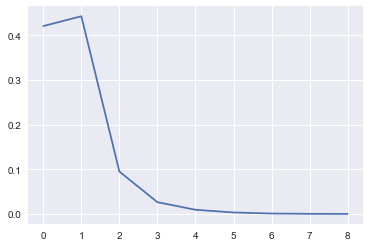

In [3]:
sns.set()
class Simulation:
    N = 20 #change this to 12
    cycle = 30
    green_time = 15
    trip_length = 10 #change to 8
    saturation = .8
    arrival_rate = (saturation * green_time)/(trip_length *
                                              cycle)  # am i calculating this right?
    interval_generator = expon(scale=1./arrival_rate)

    def __init__(self):
        self.cars = deque()
        self.exited = deque()
        self.green = False
        self.time = 0
        self.queues = map(lambda x: Queue(
            x, self.getNextTime()), range(self.N))
        for (i, queue) in enumerate(self.queues):
            queue.next = self.queues[i+1] if i < (self.N-1) else self.queues[0]

    def getNextTime(self):
        return self.time + self.interval_generator.rvs(1)[0]
    
    def green_phase(self):
        switches = []  # a list of which cars to move where

        for (i, queue) in enumerate(self.queues):
            if len(queue) > 0:  # if there are cars in the queue
                car = queue.pop()  # pop the rightmost car off the queue
                car.recordQueue(queue.ID)
                car.increment()
                if car.traveled < self.trip_length:  # if it still has somewhere to go
                    switches.append((car, queue.next))
                else:  # remove the car
                    car.setExitTime(self.time+1)
                    self.exited.append(car)

        for (car, receiving_queue) in switches:  # add traversed cars to the new queues
            receiving_queue.appendleft(car)

    def tick(self):
        self.time += 1

        if self.time % self.green_time == 0:  # this works because our green time is half our cycle length
            self.green = not self.green  # switch the signal
            if not self.green and self.time>4000:
                for queue in self.queues:
                    queue.recordQueueLength()

        if self.green:
            self.green_phase()

        for queue in self.queues:
            if queue.nextTime <= self.time:
                self.addCar(queue)
                
    def addCar(self,queue):
        car = Car(self.time)
        self.cars.append(car)
        queue.appendleft(car)
        queue.nextTime = self.getNextTime()
    
    @property
    def histories(self):
        return np.array([queue.history for queue in self.queues])

    def plotDelays(self):
        filtered = filter(lambda x: x.t_arrival > 15000, self.exited)
        delays = map(lambda x: x.t_exit-x.t_arrival, filtered)
        delays.sort()
        plt.cla()
#         sns.distplot(delays,fit=stats.gamma)
        sns.distplot(delays)
        plt.show()
        print(np.mean(delays))
        return delays
    
sim = Simulation()

for i in range(30000):
    sim.tick()
    
    
# note this doesn't work if there is some number less than M that never gets called
transitions = np.vstack([a.transitions for a in sim.queues])
M = np.max(transitions)
z = np.zeros((M+1,M+1))
for (i,j) in transitions:
    z[i][j]+=1
P = z/z.sum(axis=1,keepdims=True)
w,v = np.linalg.eig(P.T)
j_stationary = np.argmin(abs(w - 1.0))
p_stationary = v[:,j_stationary].real
p_stationary /= p_stationary.sum()
q = p_stationary
plt.plot(p_stationary)
plt.show()

# delays = sim.plotDelays()


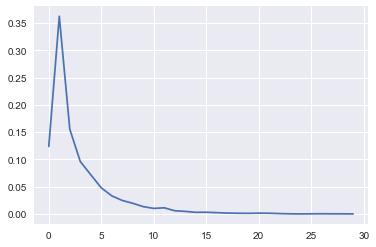

In [335]:
# note this doesn't work if there is some number less than M that never gets called
transitions = np.vstack([a.transitions for a in sim.queues])
M = np.max(transitions)
z = np.zeros((M+1,M+1))
for (i,j) in transitions:
    z[i][j]+=1
P = z/z.sum(axis=1,keepdims=True)
w,v = np.linalg.eig(P.T)
j_stationary = np.argmin(abs(w - 1.0))
p_stationary = v[:,j_stationary].real
p_stationary /= p_stationary.sum()
q = p_stationary
plt.plot(p_stationary)
plt.show()

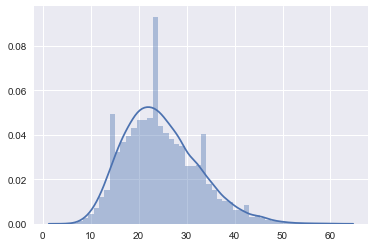

In [329]:
tripLength =10
u = [g.rvs(size=tripLength).sum()+1 for i in np.arange(10000)]
plt.cla()
sns.distplot(u)
# plt.hist(u,)
plt.show()

In [6]:
g = stats.rv_discrete(values=(np.arange(M+1),q))

In [43]:
time = 0
j = 0
trip_length = 10
while j < trip_length:
    time+=g.rvs()+1
    if time>15:
        time+=15
    j+=1
time

65